Qui troverai l'ultimo passo "dell'avventura" iniziata con [questo articolo](https://massimilianomoraca.me/blog/gis/pm10-nord-italia/) in cui riporto l'andamento del PM10 nel nord Italia nell'ultimo decennio. Il come ho proceduto all'analisi è riportato in [quest'altro articolo](https://massimilianomoraca.me/blog/pygis-blog/analisi-dellandamento-del-pm10-nel-nord-italia/).

Lo scopo dell'articolo che stai per leggere è visualizzare su mappa le aree di analisi, cosa che fino ad ora non avevo mostrato.

Tutto l'iter è stato bello lungo ed è per questo che l'ho dovuto suddividere in ben tre differenti articoli.

# Prima di iniziare

## Librerie

Come per tutti gli [articoli di PyGIS-Blog](https://massimilianomoraca.me/blog/pygis-blog/) inizio con l'elenco delle librerie usate. Una menzione speciale è per la funzione `xarray.open_mfdataset` perchè mi ha consentito di velocizzare tantissimo la lettura di tutti i file `.nc` grazie al nativo supporto a `dask.delayed`. 

Devo approfondire Dask appena ho tempo e [Dask Delayed](https://docs.dask.org/en/stable/delayed.html) sembra un buon punto di partenza pratico su cui lavorare per il mio solito training on the job :)

In [40]:
from pathlib import Path
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

## Fonti dati

Come già spiegato nei precedenti articoli di questa involontaria miniserie, i dati usati sono quelli distributi dal Copernicus Atmosphere Monitoring Service. In particolare ho usato dati con una copertura temporale che va dal 2013 a marzo 2024.

In [2]:
nc_data_path = Path("/home/max/Desktop/pianura_padana/processed/netcdf")

nc_files = list(nc_data_path.glob("*.nc"))

nc_files

[PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2021-forecasts.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2017-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2020-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2014-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2013-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2016-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2023-forecasts.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2019-reanalyses.nc'),
 PosixPath('/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2015-reanalyses.nc'),
 PosixPath('/home/max/Desktop/

L'area geografica è sempre quella dei precedenti due articoli, la riporto comunque di seguito per completezza.

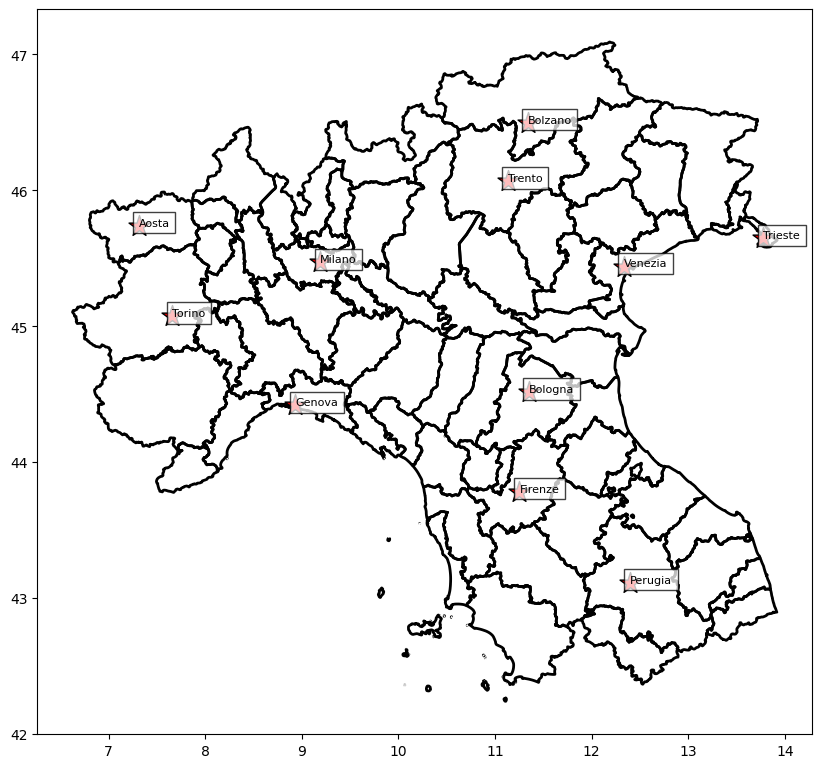

In [70]:
main_city_path = Path.cwd().joinpath('data', 'citta_significative.shp')
main_city = gpd.read_file(main_city_path)

target_zones_boundaries = Path.cwd().parent.parent.parent.parent.joinpath('sample_data').joinpath('ProvCM01012023_g').joinpath('ProvCM01012023_g_WGS84.shp')

target_zones = gpd.read_file(target_zones_boundaries)
target_zones = target_zones[target_zones['COD_REG'].isin(list(range(1, 12)))]
target_zones = target_zones.to_crs(4326).sort_values('DEN_UTS')


fig1, ax1 = plt.subplots(figsize=(10, 10))
target_zones.plot(
    ax=ax1,
    facecolor="none", 
    edgecolor="black",
    linewidth=2.0
)
for _index, _row in main_city.iterrows():
    coordinates = _row.geometry.xy
    ax1.scatter(
        *coordinates,
        s=250,
        marker="*",
        facecolor='red',
        edgecolor='black'
    )
    plt.text(
        x=coordinates[0][0],
        y=coordinates[1][0],
        s=_row.citta,
        fontdict=dict(color='black', size=8),
        bbox=dict(facecolor='white', alpha=0.75)
    )
plt.show()

# Singolo file

## Lettura del `.nc`

Prima di iterare tutto il processo sull'intero arco temporale ho preferito effettuare delle verifiche su un solo anno, anche per prendere meglio confidenza con i dati.

In [71]:
single_dataset = xr.open_dataset(
    filename_or_obj='/home/max/Desktop/pianura_padana/processed/netcdf/particulate_matter_10um-2013-reanalyses.nc',
    engine="netcdf4",
    decode_coords="all",
)

single_dataset

<xarray.Dataset> Size: 163MB
Dimensions:                  (time: 8760, lon: 91, lat: 51)
Coordinates:
  * time                     (time) datetime64[ns] 70kB 2013-01-01 ... 2013-1...
  * lon                      (lon) float64 728B 6.0 6.1 6.2 ... 14.8 14.9 15.0
  * lat                      (lat) float64 408B 42.0 42.1 42.2 ... 46.9 47.0
    spatial_ref              int64 8B ...
    level                    int64 8B ...
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 163MB ...
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

Come si può vedere, il Dataset del 2013 è composto da 8760 ore (24h x 365d) per un peso di ben 163MB. Ricordo che la risoluzione spaziale di questi dati è circa 7.5km x 7.5km.

### Test singolo giorno

Di seguito punto all'estrazione e visualizzazione di una singola ora di un singolo giorno.

In [72]:
target_test_time = '2013-07-09T13:00:00'

target_hour_selection = single_dataset.sel(time=target_test_time).to_array().squeeze()
#target_hour_sel = target_hour_sel.rename({'lon': 'x', 'lat': 'y'})

target_hour_selection

<xarray.DataArray (lat: 51, lon: 91)> Size: 19kB
array([[32.88422  , 32.85841  , 32.44171  , ..., 13.436613 , 14.311139 ,
        15.214118 ],
       [33.01072  , 32.81864  , 32.40152  , ..., 15.240301 , 15.444803 ,
        15.649314 ],
       [33.0541   , 32.07483  , 31.37025  , ..., 15.6916895, 15.567043 ,
        15.631379 ],
       ...,
       [14.526992 , 14.565249 , 14.565497 , ..., 19.279963 , 19.53084  ,
        19.920486 ],
       [14.2113695, 14.210173 , 14.210417 , ..., 19.572437 , 20.62339  ,
        20.301117 ],
       [14.699474 , 14.72564  , 14.72589  , ..., 20.786325 , 21.017164 ,
        20.689896 ]], dtype=float32)
Coordinates:
    time         datetime64[ns] 8B 2013-07-09T13:00:00
  * lon          (lon) float64 728B 6.0 6.1 6.2 6.3 6.4 ... 14.7 14.8 14.9 15.0
  * lat          (lat) float64 408B 42.0 42.1 42.2 42.3 ... 46.7 46.8 46.9 47.0
    spatial_ref  int64 8B ...
    level        int64 8B ...
    variable     <U23 92B 'particulate_matter_10um'
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

In [73]:
s_min = target_hour_selection.min().values.round(2)
s_max = target_hour_selection.max().values.round(2)

print(f"Nell'ora presa in considerazione si nota che il PM10 minimo era pari a {s_min} µg/m3 ed il massimo era {s_max} µg/m3")

Nell'ora presa in considerazione si nota che il PM10 minimo era pari a 2.180000066757202 µg/m3 ed il massimo era 37.630001068115234 µg/m3


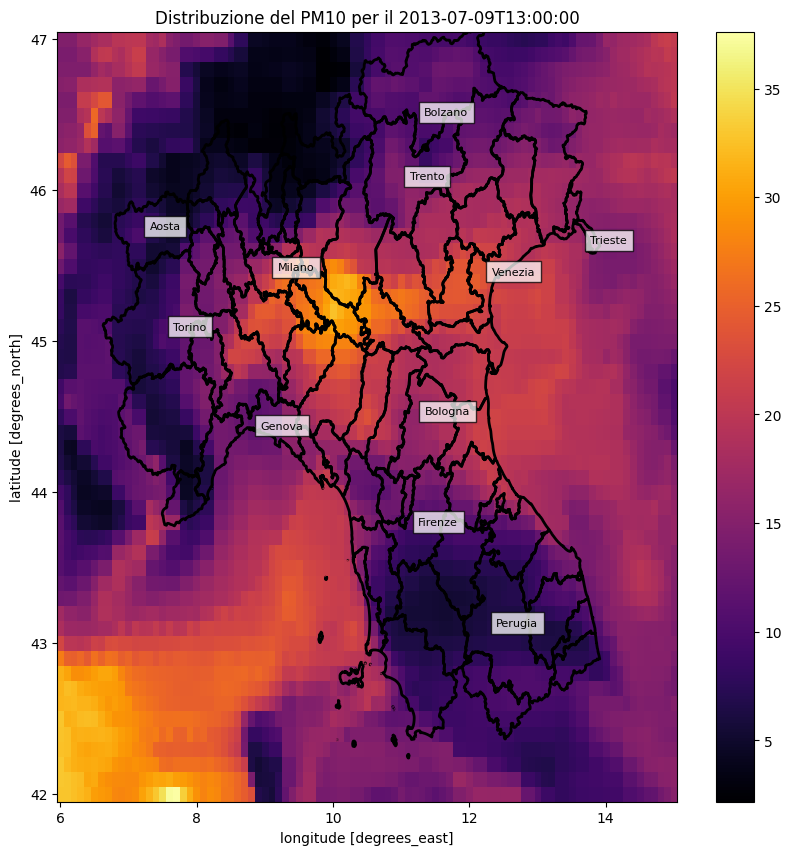

In [79]:
fig2, ax2 = plt.subplots(figsize=(10, 10))
target_zones.plot(
    ax=ax2,
    facecolor="none", 
    edgecolor="black",
    linewidth=2.0
)
target_hour_selection.plot.imshow(
    ax=ax2,
    cmap='inferno',
)
for _index, _row in main_city.iterrows():
    coordinates = _row.geometry.xy
    ax1.scatter(
        *coordinates,
        s=250,
        marker="*",
        facecolor='red',
        edgecolor='black'
    )
    plt.text(
        x=coordinates[0][0],
        y=coordinates[1][0],
        s=_row.citta,
        fontdict=dict(color='black', size=8),
        bbox=dict(facecolor='white', alpha=0.75)
    )
plt.title(f"Distribuzione del PM10 per il {target_test_time}")
plt.show()

## Conteggio degli sforamenti in un anno

Di seguito calcolo la media giornaliera per tutto l'anno in esame.

In [81]:
daily_data = single_dataset.resample(time='D').mean('time')  

daily_data

<xarray.Dataset> Size: 7MB
Dimensions:                  (lon: 91, lat: 51, time: 365)
Coordinates:
  * lon                      (lon) float64 728B 6.0 6.1 6.2 ... 14.8 14.9 15.0
  * lat                      (lat) float64 408B 42.0 42.1 42.2 ... 46.9 47.0
    spatial_ref              int64 8B 0
    level                    int64 8B 0
  * time                     (time) datetime64[ns] 3kB 2013-01-01 ... 2013-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 7MB 14.59 14.76 ... 15.35
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

Quindi seleziono le sole celle che sforano il limite di 50 µg/m3 previsti dalla normativa.

In [83]:
daily_data_target = daily_data.copy()
daily_data_target['particulate_matter_10um'] = xr.where(daily_data['particulate_matter_10um'] >= 50, 1, 0)

daily_data_target

<xarray.Dataset> Size: 14MB
Dimensions:                  (lon: 91, lat: 51, time: 365)
Coordinates:
  * lon                      (lon) float64 728B 6.0 6.1 6.2 ... 14.8 14.9 15.0
  * lat                      (lat) float64 408B 42.0 42.1 42.2 ... 46.9 47.0
    spatial_ref              int64 8B 0
    level                    int64 8B 0
  * time                     (time) datetime64[ns] 3kB 2013-01-01 ... 2013-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) int64 14MB 0 0 0 0 0 ... 0 0 0 0 0
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

I pixel che sforano il limite li ho sostituiti con il valore 1 e gli altri con 0, in questo modo con il passaggio successivo ho potuto calcolare quante volte viene sforato il limite.

In [84]:
year_data = daily_data_target.resample(time='YE').sum('time')  

year_data

<xarray.Dataset> Size: 38kB
Dimensions:                  (lon: 91, lat: 51, time: 1)
Coordinates:
  * lon                      (lon) float64 728B 6.0 6.1 6.2 ... 14.8 14.9 15.0
  * lat                      (lat) float64 408B 42.0 42.1 42.2 ... 46.9 47.0
    spatial_ref              int64 8B 0
    level                    int64 8B 0
  * time                     (time) datetime64[ns] 8B 2013-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) int64 37kB 0 0 0 0 0 ... 0 0 0 0 0
Attributes:
    Conventions:  CF-1.7
    Title:        CAMS European air quality interim reanalysis
    Provider:     COPERNICUS European air quality service
    Production:   COPERNICUS Atmosphere Monitoring Service
    pollutant:    particulate_matter_10um
    sea_level:    0

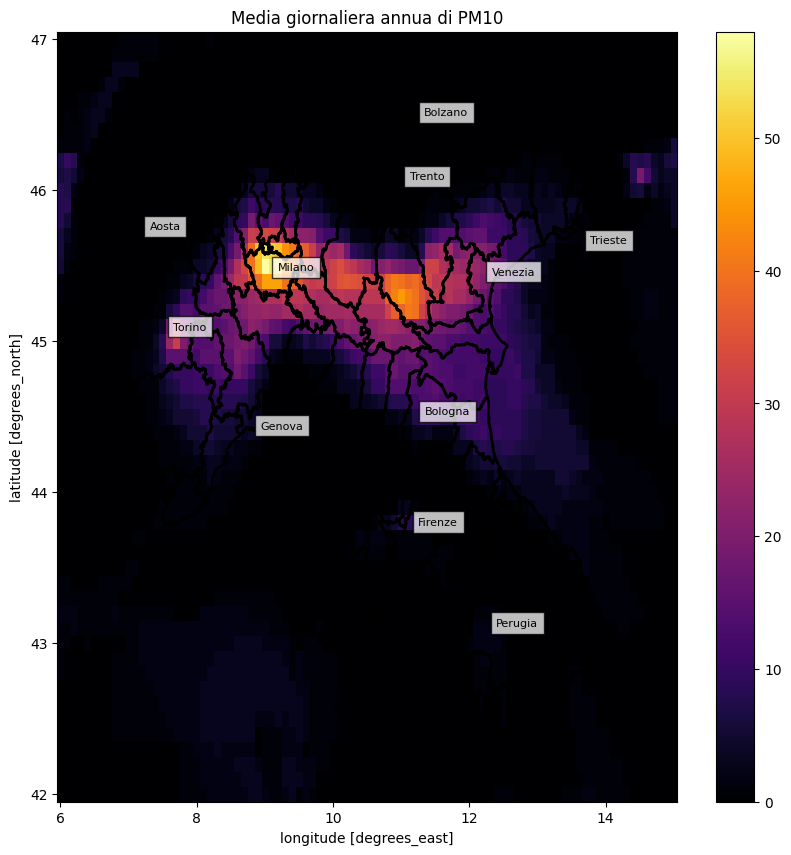

In [87]:
fig3, ax3 = plt.subplots(figsize=(10, 10))
target_zones.plot(
    ax=ax3,
    facecolor="none", 
    edgecolor="black",
    linewidth=2.0
)
year_data.to_array().squeeze().plot.imshow(
    ax=ax3,
    cmap='inferno',
)
for _index, _row in main_city.iterrows():
    coordinates = _row.geometry.xy
    ax1.scatter(
        *coordinates,
        s=250,
        marker="*",
        facecolor='red',
        edgecolor='black'
    )
    plt.text(
        x=coordinates[0][0],
        y=coordinates[1][0],
        s=_row.citta,
        fontdict=dict(color='black', size=8),
        bbox=dict(facecolor='white', alpha=0.75)
    )
plt.title("Media giornaliera annua di PM10")
plt.show()

# Analisi di tutti i file

Ora che ho familiarizzato con il dato del singolo anno procedo ad analizzare tutto in una unica volta.

In [92]:
%%time

complete_dataset = []

for nc_file in nc_files:
    dataset = xr.open_mfdataset(
        paths=nc_file,
        engine="netcdf4",
        decode_coords="all",
        parallel=True,
        chunks={'time': 24},
    )
    complete_dataset.append(dataset)

full_dataset = xr.concat(complete_dataset, dim="time")
full_dataset = full_dataset.sortby('time')

full_dataset

CPU times: user 188 ms, sys: 9.54 ms, total: 197 ms
Wall time: 198 ms


<xarray.Dataset> Size: 20GB
Dimensions:                  (lon: 331, lat: 151, time: 98136)
Coordinates:
  * lon                      (lon) float64 3kB 6.0 6.0 6.05 ... 14.95 14.95 15.0
  * lat                      (lat) float64 1kB 42.0 42.05 42.05 ... 46.95 47.0
  * time                     (time) datetime64[ns] 785kB 2013-01-01 ... 2024-...
    level                    float32 4B 0.0
    spatial_ref              int64 8B 0
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 20GB dask.array<chunksize=(24, 151, 331), meta=np.ndarray>
Attributes:
    title:        PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210101-20210131+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of PM10 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)
    pollutant:    particulate_matter_10um
    sea_level:    0

Da notare che l'intero dataset pesa 20GB!

Procedo con il calcolo della media giornaliera e la sostituzione dei valori di sforamento con 1.

In [93]:
%%time

full_dataset_daily_data = full_dataset.resample(time='D').mean('time')  

full_dataset_daily_data

CPU times: user 8.63 s, sys: 39.8 ms, total: 8.67 s
Wall time: 8.61 s


<xarray.Dataset> Size: 818MB
Dimensions:                  (lon: 331, lat: 151, time: 4089)
Coordinates:
  * lon                      (lon) float64 3kB 6.0 6.0 6.05 ... 14.95 14.95 15.0
  * lat                      (lat) float64 1kB 42.0 42.05 42.05 ... 46.95 47.0
    level                    float32 4B 0.0
    spatial_ref              int64 8B 0
  * time                     (time) datetime64[ns] 33kB 2013-01-01 ... 2024-0...
Data variables:
    particulate_matter_10um  (time, lat, lon) float32 817MB dask.array<chunksize=(1, 151, 331), meta=np.ndarray>
Attributes:
    title:        PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210101-20210131+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of PM10 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)
    pollutant:    particulate_matter_10um
    sea_level:    0

In [94]:
%%time

full_dataset_daily_data_target = full_dataset_daily_data.copy()
full_dataset_daily_data_target['particulate_matter_10um'] = xr.where(full_dataset_daily_data_target['particulate_matter_10um'] > 50, 1, 0)

full_dataset_daily_data_target

CPU times: user 17.5 ms, sys: 345 µs, total: 17.8 ms
Wall time: 17.8 ms


<xarray.Dataset> Size: 2GB
Dimensions:                  (lon: 331, lat: 151, time: 4089)
Coordinates:
  * lon                      (lon) float64 3kB 6.0 6.0 6.05 ... 14.95 14.95 15.0
  * lat                      (lat) float64 1kB 42.0 42.05 42.05 ... 46.95 47.0
    level                    float32 4B 0.0
    spatial_ref              int64 8B 0
  * time                     (time) datetime64[ns] 33kB 2013-01-01 ... 2024-0...
Data variables:
    particulate_matter_10um  (time, lat, lon) int64 2GB dask.array<chunksize=(1, 151, 331), meta=np.ndarray>
Attributes:
    title:        PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210101-20210131+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of PM10 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)
    pollutant:    particulate_matter_10um
    sea_level:    0

A questo punto posso conteggiare gli sforamenti per tutto il dataset

In [95]:
full_dataset_year_data = full_dataset_daily_data_target.resample(time='YE').sum('time')  

full_dataset_year_data

<xarray.Dataset> Size: 5MB
Dimensions:                  (lon: 331, lat: 151, time: 12)
Coordinates:
  * lon                      (lon) float64 3kB 6.0 6.0 6.05 ... 14.95 14.95 15.0
  * lat                      (lat) float64 1kB 42.0 42.05 42.05 ... 46.95 47.0
    level                    float32 4B 0.0
    spatial_ref              int64 8B 0
  * time                     (time) datetime64[ns] 96B 2013-12-31 ... 2024-12-31
Data variables:
    particulate_matter_10um  (time, lat, lon) int64 5MB dask.array<chunksize=(1, 151, 331), meta=np.ndarray>
Attributes:
    title:        PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210101-20210131+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of PM10 concentration at the...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)
    pollutant:    particulate_matter_10um
    sea_level:    0

Il dataset a questo punto si è ridotto a 5MB.

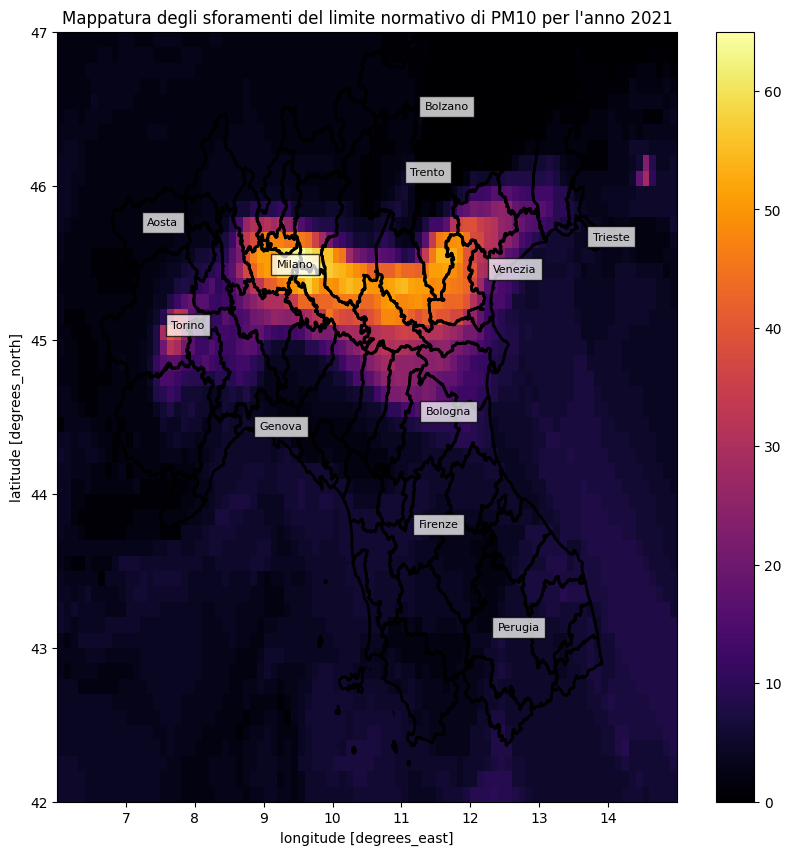

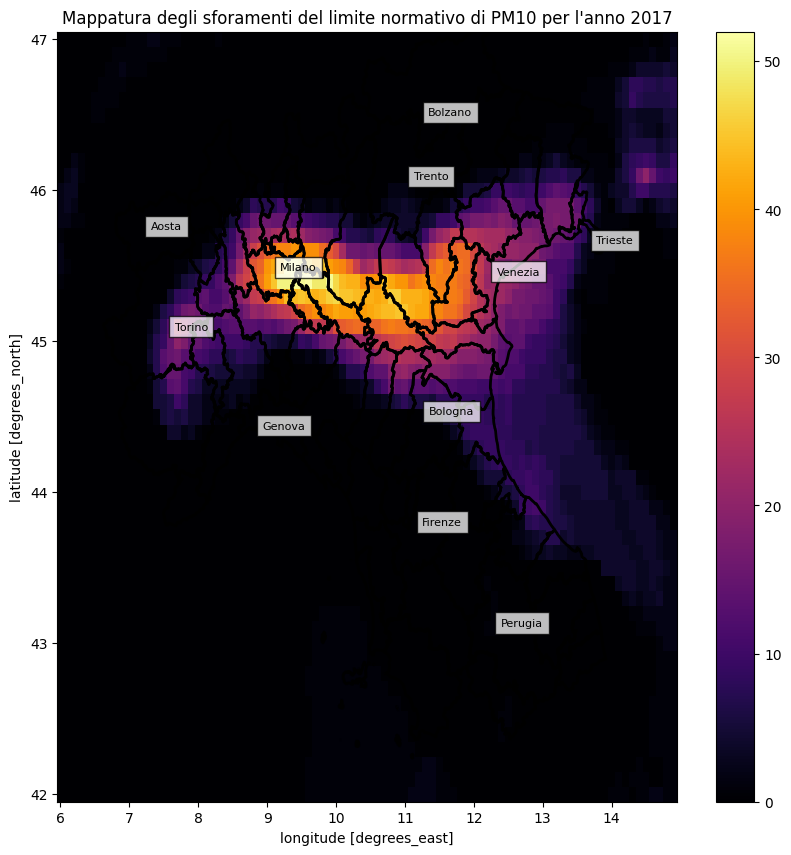

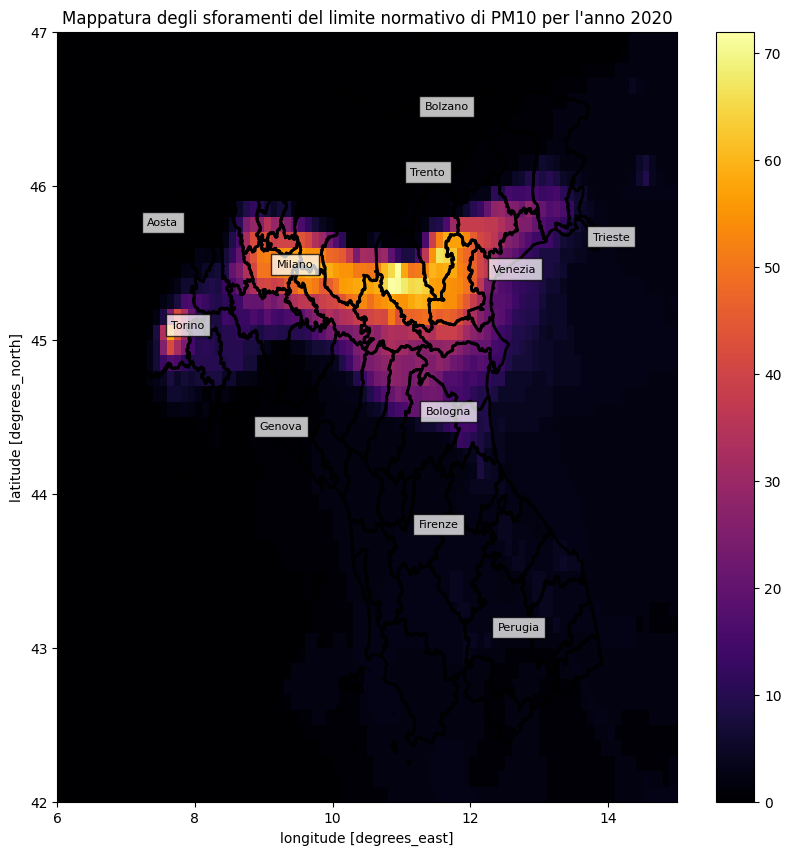

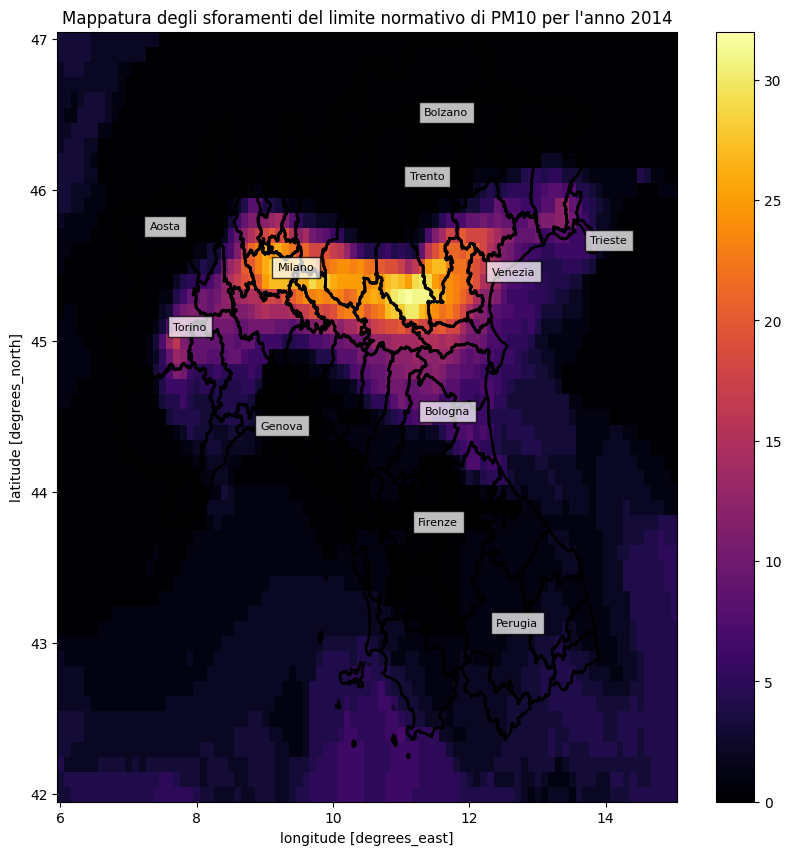

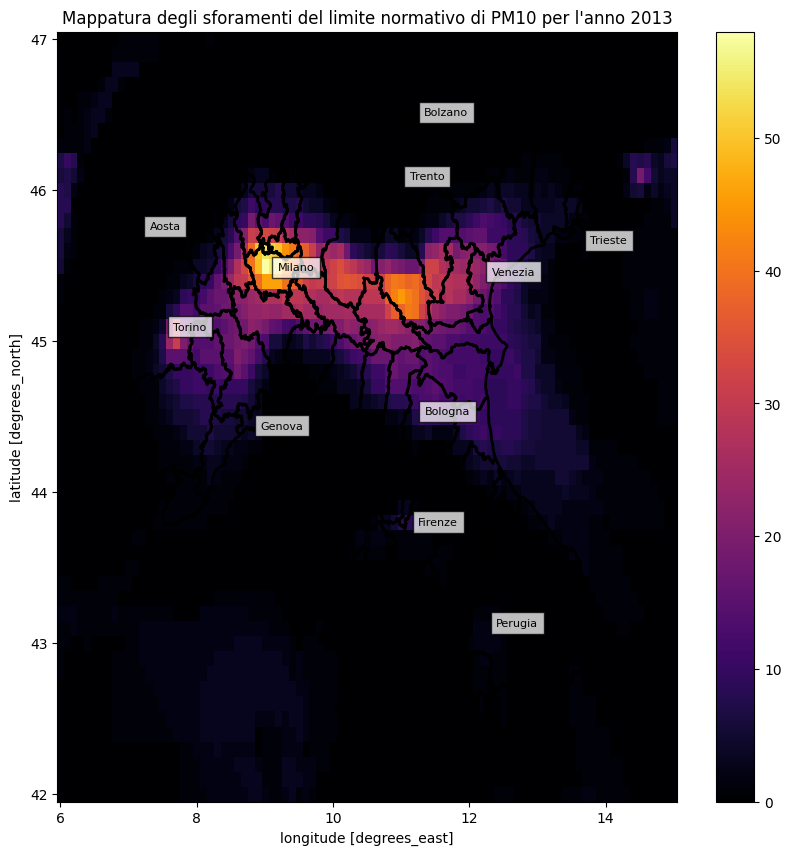

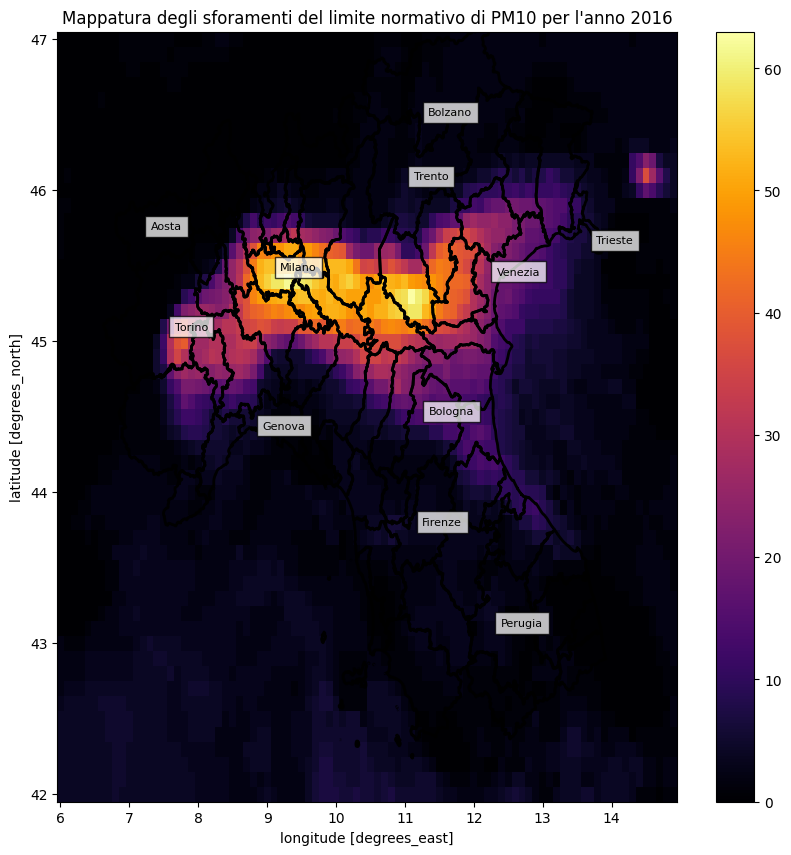

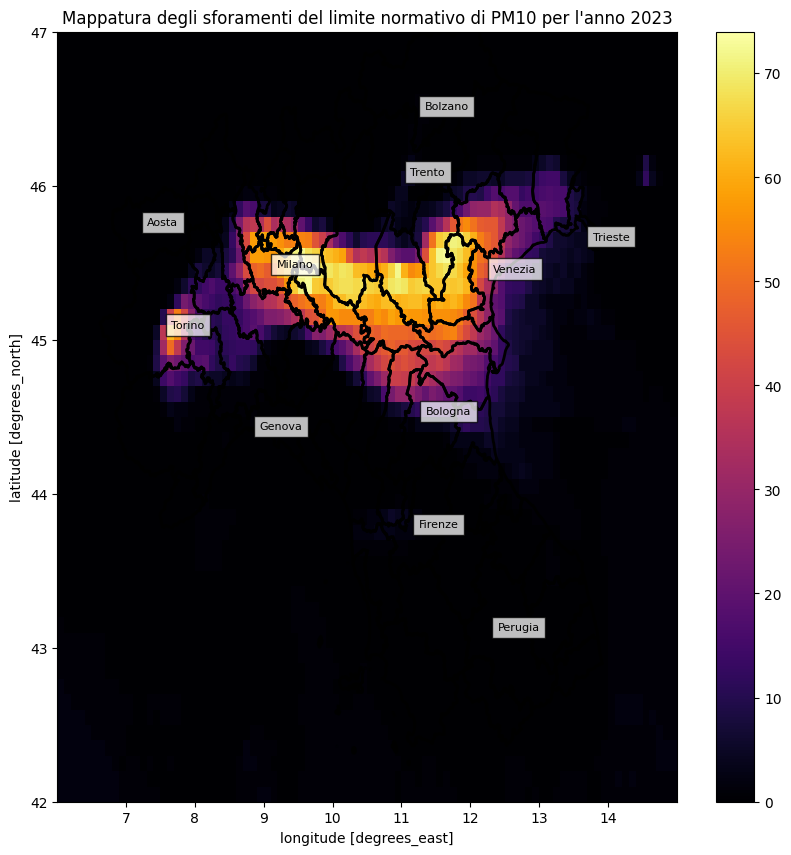

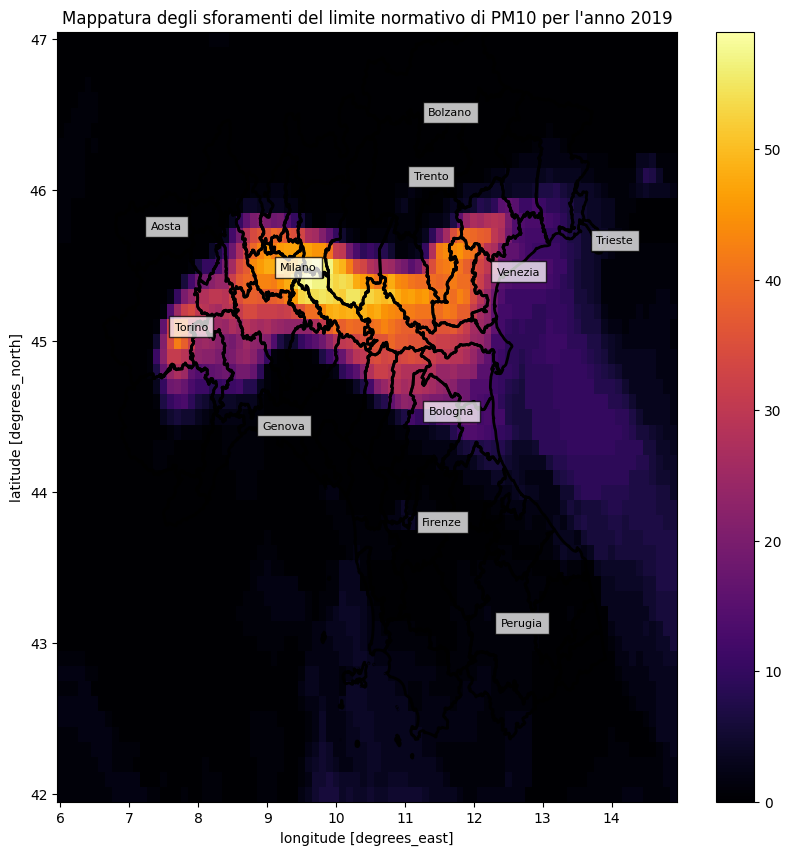

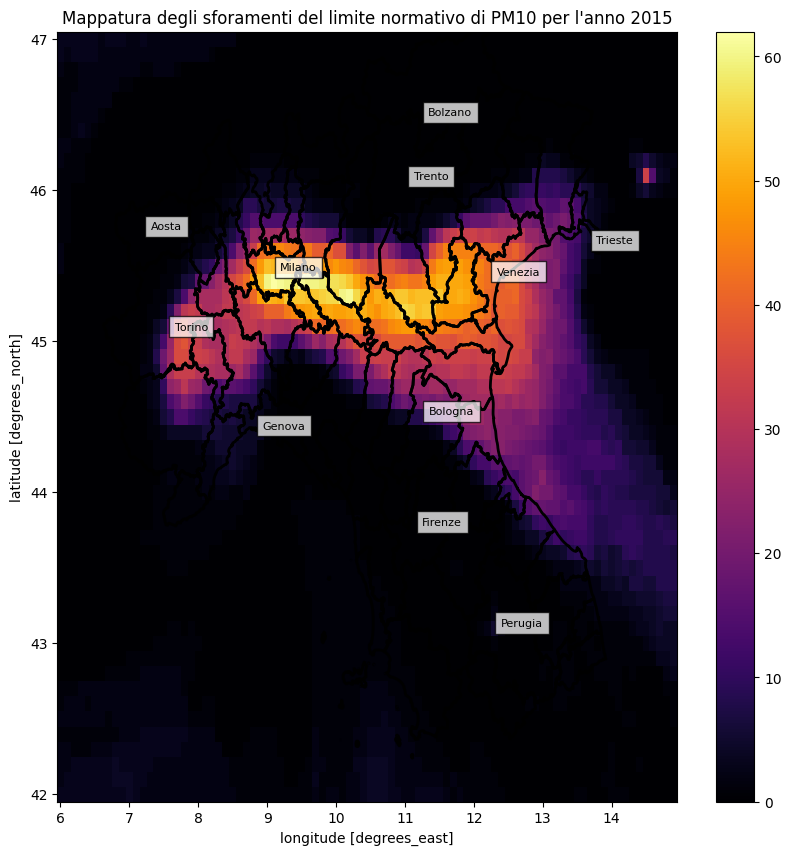

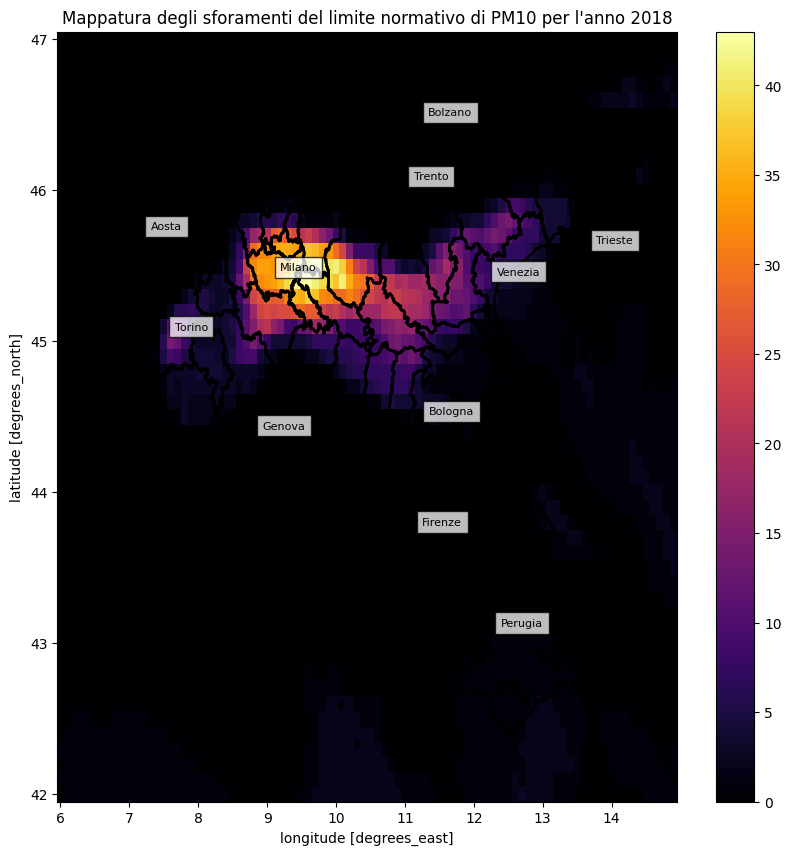

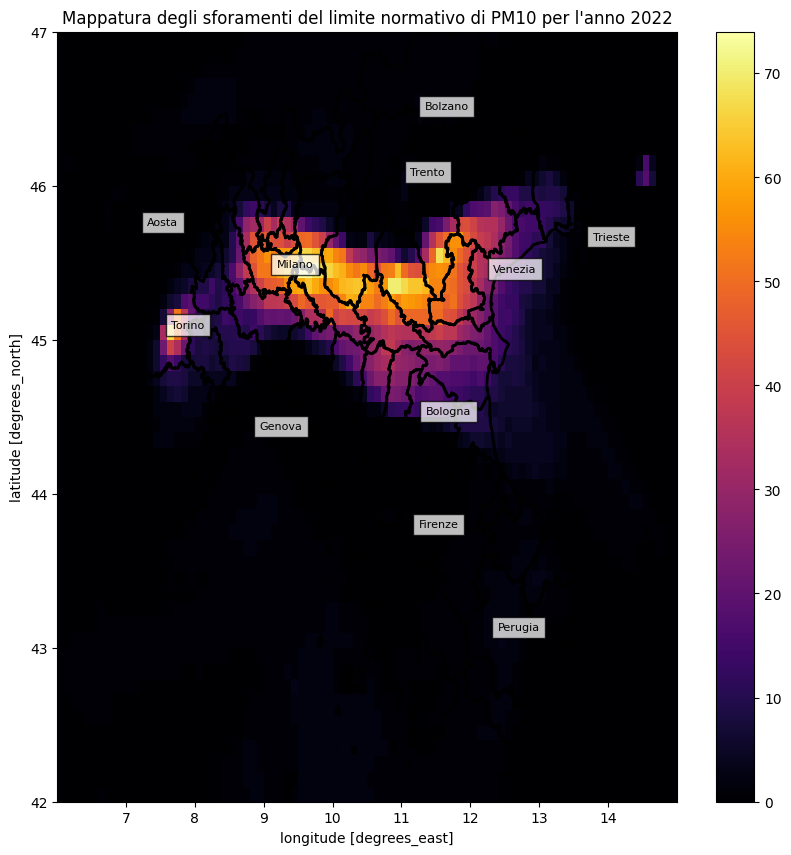

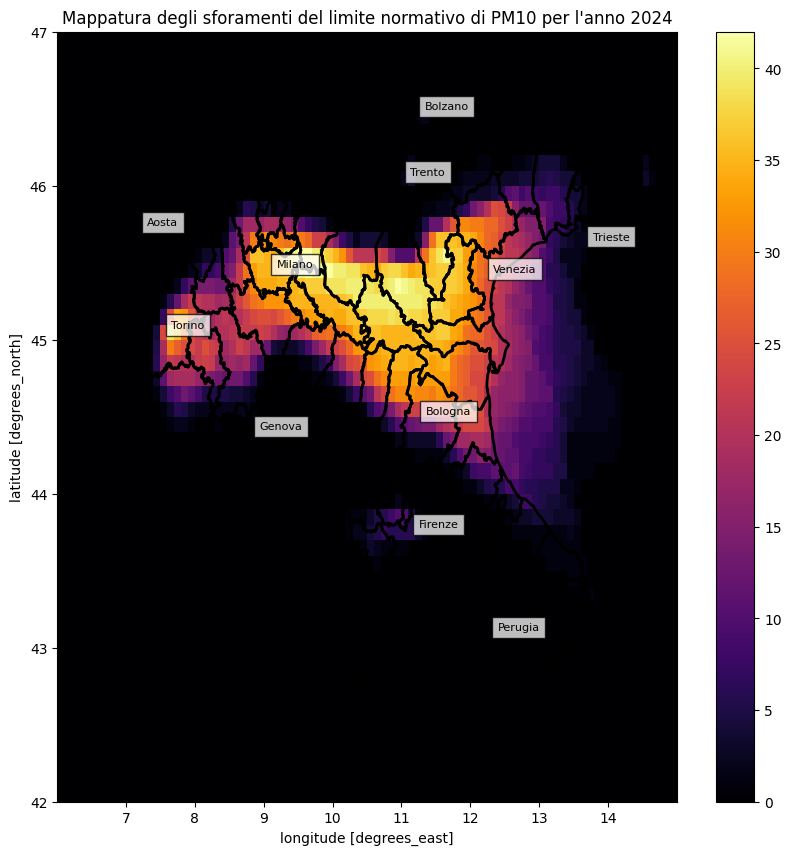

CPU times: user 20.8 s, sys: 3.14 s, total: 23.9 s
Wall time: 19.1 s


In [97]:
%%time

dataset_list = []
variable = 'particulate_matter_10um'
target_shape = (50, 90)


for nc_file in nc_files:
    dataset = xr.open_mfdataset(
        paths=nc_file,
        engine="netcdf4",
        decode_coords="all",
        parallel=True,
        chunks={'time': 24},
    )
    dataset = dataset.sortby('time')
    
    daily_mean = dataset.resample(time='D').mean('time')  

    anomaly = daily_mean.copy()
    anomaly[variable] = xr.where(daily_mean[variable] >= 50, 1, 0)
    
    out_layer = anomaly.resample(time='YE').sum('time')  
    year = str(out_layer['time'].values[0])[:4]

    fig4, ax4 = plt.subplots(figsize=(10, 10))
    target_zones.plot(
        ax=ax4,
        facecolor="none", 
        edgecolor="black",
        linewidth=2.0
    )
    out_layer.to_array().squeeze().plot.imshow(
        ax=ax4,
        cmap='inferno',
    )
    for _index, _row in main_city.iterrows():
        coordinates = _row.geometry.xy
        ax1.scatter(
            *coordinates,
            s=250,
            marker="*",
            facecolor='red',
            edgecolor='black'
        )
        plt.text(
            x=coordinates[0][0],
            y=coordinates[1][0],
            s=_row.citta,
            fontdict=dict(color='black', size=8),
            bbox=dict(facecolor='white', alpha=0.75)
        )
    plt.title(f"Mappatura degli sforamenti del limite normativo di PM10 per l'anno {year}")
    plt.show()
